In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series 
from pandas import concat
from pandas import datetime
import numpy as np
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from math import sqrt
from PyEMD import EMD
from PyEMD import EEMD
from math import log, ceil, sqrt
from statistics import mean
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-5a82ac8e156f>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df = pd.read_csv("GuaMusang_imputed.csv", parse_dates = ['Date'], na_values='?')
print(df['Rainfall'].isnull().sum())

df['Date'] = pd.date_range(start='1/1/1982', end='31/12/2020')
df.set_index('Date',inplace=True)

df = df.resample('M').sum()
df = df.iloc[:-12,:]
df

0


,Rainfall
Date,
1982-01-31,20.0
1982-02-28,67.0
1982-03-31,186.0
1982-04-30,243.0
1982-05-31,167.0
...,...
2019-08-31,216.0
2019-09-30,272.0
2019-10-31,285.0


In [3]:
s = df.values

emd = EMD()
x = s.flatten()
print("x:",x)

IMF = emd.emd(x)
print(IMF)
print(len(IMF[1]))
print(len(IMF[2]))
print(len(IMF[3]))
print(len(IMF))
print('-------trying loop--------')
for i in range(len(IMF)):
    print(IMF[i])
    
print('one IMF COMPLETE')
N=IMF.shape[0]+1

x: [ 20.   67.  186.  243.  167.   96.9 187.8 226.  336.  225.  233.  275.1
  78.    6.   14.   45.5 108.5 208.  287.  230.  300.  116.  172.  487.2
 326.8 297.  284.  205.  412.  202.  223.  115.  250.  332.  102.   92.
  73.5 108.  248.   98.  343.   86.  134.7 243.  301.  296.  262.   58.
 122.   21.8  60.  299.  155.  131.  130.  167.  410.5 404.  412.5 229.5
 112.    0.  128.7  59.8 172.1  71.3  39.9 198.8 260.8 285.7 265.  345.
  90.4 121.  137.   84.5 122.  509.5 204.5 274.3 337.  153.3 746.  148.5
 197.5   4.5 179.  229.  231.  216.  198.5  73.7 154.9 453.8 100.5  66.
 221.   56.   27.  111.  202.  109.  277.  118.  358.  238.  229.5 269.
 153.   36.2 145.5 185.  279.5  98.5 120.5 193.  338.  281.5 248.5 407.5
  63.5  32.5   0.    0.   14.5 243.5 316.5  70.5 222.5 276.5 340.5 265.
  60.   59.   96.5 374.5 186.5 398.5 242.  160.5 309.5 540.  306.5 348.5
  75.5  70.  150.  206.5 330.5 234.   79.  274.5 306.5 409.  425.5 124.
 176.5  64.   71.5 186.  196.5 233.  128.5 384.5 175.5 

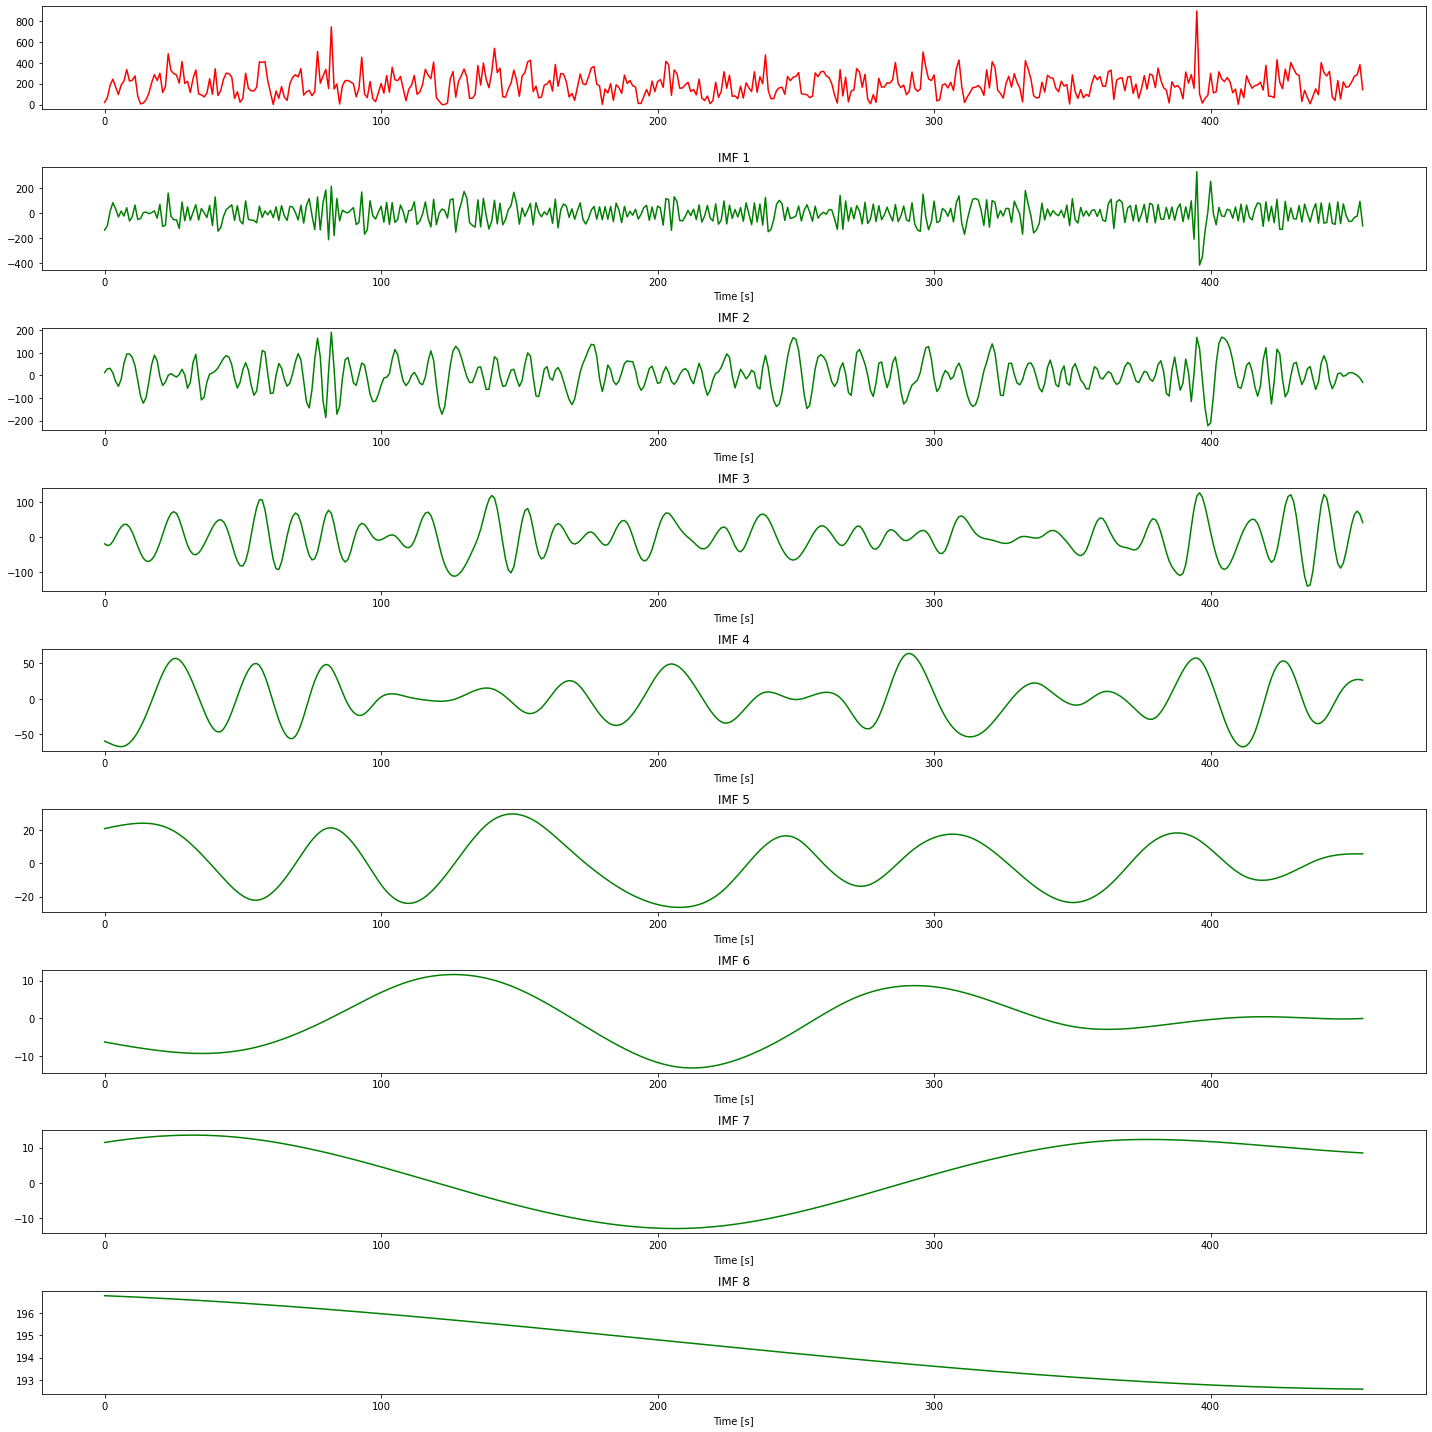

In [4]:
plt.figure(figsize=(20,20))
plt.subplot(N,1,1)
plt.plot(s, 'r')

#plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
#plt.xlabel("Time [s]")
for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")
plt.tight_layout()

#plt.savefig('simple_example')
plt.show()
plt.show()

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def lstm_model():
    model = Sequential()
    model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [8]:
def r2_det(y, yhat):
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    #ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    #sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    #sserror = np.sum((y - yhat)**2)
    
    sserror = sum([(yi - yihat)**2 for yi, yihat in zip(y, yhat)])
    ssreg = sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = sum([ (yi - ybar)**2 for yi in y])
    #results['determination'] = ssreg / sstot

    return 1 - (sserror / sstot)

Epoch 1/100
26/26 - 2s - loss: 0.1796 - val_loss: 0.1964
Epoch 2/100
26/26 - 0s - loss: 0.1748 - val_loss: 0.1925
Epoch 3/100
26/26 - 0s - loss: 0.1679 - val_loss: 0.1906
Epoch 4/100
26/26 - 0s - loss: 0.1624 - val_loss: 0.1861
Epoch 5/100
26/26 - 0s - loss: 0.1583 - val_loss: 0.1884
Epoch 6/100
26/26 - 0s - loss: 0.1558 - val_loss: 0.1839
Epoch 7/100
26/26 - 0s - loss: 0.1539 - val_loss: 0.1798
Epoch 8/100
26/26 - 0s - loss: 0.1530 - val_loss: 0.1780
Epoch 9/100
26/26 - 0s - loss: 0.1522 - val_loss: 0.1762
Epoch 10/100
26/26 - 0s - loss: 0.1512 - val_loss: 0.1736
Epoch 11/100
26/26 - 0s - loss: 0.1506 - val_loss: 0.1750
Epoch 12/100
26/26 - 0s - loss: 0.1507 - val_loss: 0.1751
Epoch 13/100
26/26 - 0s - loss: 0.1503 - val_loss: 0.1755
Epoch 14/100
26/26 - 0s - loss: 0.1503 - val_loss: 0.1756
Epoch 15/100
26/26 - 0s - loss: 0.1500 - val_loss: 0.1747
Epoch 16/100
26/26 - 0s - loss: 0.1499 - val_loss: 0.1757
Epoch 17/100
26/26 - 0s - loss: 0.1505 - val_loss: 0.1753
Epoch 18/100
26/26 - 0s

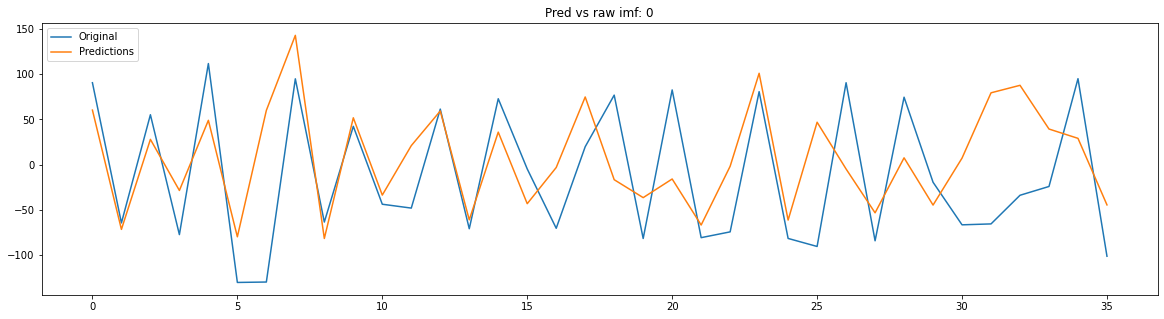

Epoch 1/100
26/26 - 2s - loss: 0.2520 - val_loss: 0.2274
Epoch 2/100
26/26 - 0s - loss: 0.2257 - val_loss: 0.2183
Epoch 3/100
26/26 - 0s - loss: 0.2143 - val_loss: 0.2089
Epoch 4/100
26/26 - 0s - loss: 0.2039 - val_loss: 0.1972
Epoch 5/100
26/26 - 0s - loss: 0.1932 - val_loss: 0.1839
Epoch 6/100
26/26 - 0s - loss: 0.1789 - val_loss: 0.1635
Epoch 7/100
26/26 - 0s - loss: 0.1522 - val_loss: 0.1513
Epoch 8/100
26/26 - 0s - loss: 0.1220 - val_loss: 0.1655
Epoch 9/100
26/26 - 0s - loss: 0.1144 - val_loss: 0.1131
Epoch 10/100
26/26 - 0s - loss: 0.0882 - val_loss: 0.1295
Epoch 11/100
26/26 - 0s - loss: 0.0825 - val_loss: 0.0990
Epoch 12/100
26/26 - 0s - loss: 0.0885 - val_loss: 0.1195
Epoch 13/100
26/26 - 0s - loss: 0.0779 - val_loss: 0.0940
Epoch 14/100
26/26 - 0s - loss: 0.0784 - val_loss: 0.1080
Epoch 15/100
26/26 - 0s - loss: 0.0721 - val_loss: 0.1011
Epoch 16/100
26/26 - 0s - loss: 0.0743 - val_loss: 0.0988
Epoch 17/100
26/26 - 0s - loss: 0.0688 - val_loss: 0.0994
Epoch 18/100
26/26 - 0s

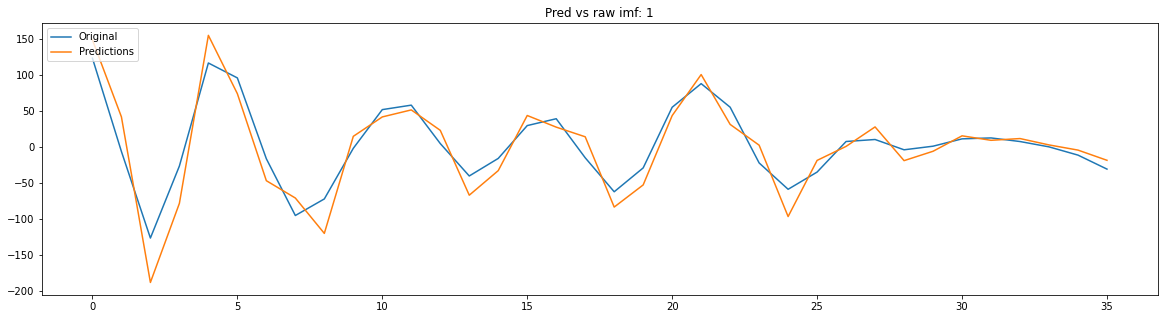

Epoch 1/100
26/26 - 2s - loss: 0.2720 - val_loss: 0.2150
Epoch 2/100
26/26 - 0s - loss: 0.2127 - val_loss: 0.2097
Epoch 3/100
26/26 - 0s - loss: 0.1812 - val_loss: 0.1495
Epoch 4/100
26/26 - 0s - loss: 0.1555 - val_loss: 0.1494
Epoch 5/100
26/26 - 0s - loss: 0.1346 - val_loss: 0.1177
Epoch 6/100
26/26 - 0s - loss: 0.1166 - val_loss: 0.1057
Epoch 7/100
26/26 - 0s - loss: 0.0922 - val_loss: 0.0980
Epoch 8/100
26/26 - 0s - loss: 0.0776 - val_loss: 0.0727
Epoch 9/100
26/26 - 0s - loss: 0.0745 - val_loss: 0.0611
Epoch 10/100
26/26 - 0s - loss: 0.0508 - val_loss: 0.0782
Epoch 11/100
26/26 - 0s - loss: 0.0493 - val_loss: 0.0509
Epoch 12/100
26/26 - 0s - loss: 0.0441 - val_loss: 0.0612
Epoch 13/100
26/26 - 0s - loss: 0.0384 - val_loss: 0.0564
Epoch 14/100
26/26 - 0s - loss: 0.0466 - val_loss: 0.0467
Epoch 15/100
26/26 - 0s - loss: 0.0358 - val_loss: 0.0526
Epoch 16/100
26/26 - 0s - loss: 0.0344 - val_loss: 0.0413
Epoch 17/100
26/26 - 0s - loss: 0.0353 - val_loss: 0.0528
Epoch 18/100
26/26 - 0s

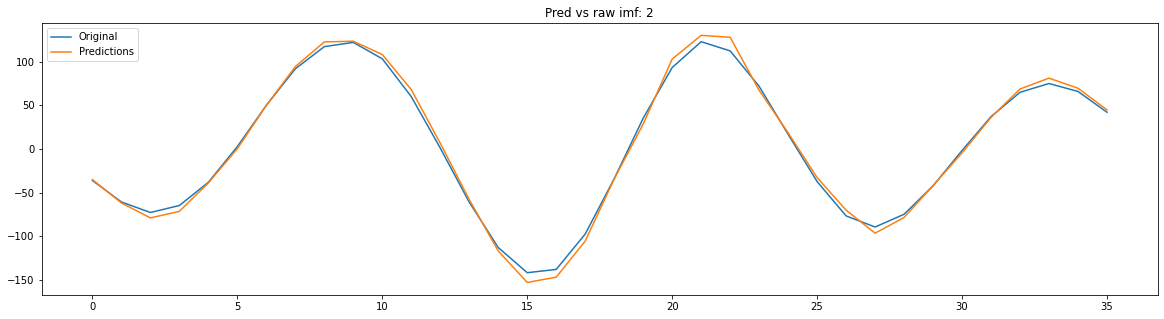

Epoch 1/100
26/26 - 2s - loss: 0.2395 - val_loss: 0.1427
Epoch 2/100
26/26 - 0s - loss: 0.1530 - val_loss: 0.1254
Epoch 3/100
26/26 - 0s - loss: 0.0967 - val_loss: 0.0860
Epoch 4/100
26/26 - 0s - loss: 0.1043 - val_loss: 0.0633
Epoch 5/100
26/26 - 0s - loss: 0.0869 - val_loss: 0.0658
Epoch 6/100
26/26 - 0s - loss: 0.0897 - val_loss: 0.0614
Epoch 7/100
26/26 - 0s - loss: 0.0608 - val_loss: 0.0734
Epoch 8/100
26/26 - 0s - loss: 0.0909 - val_loss: 0.0807
Epoch 9/100
26/26 - 0s - loss: 0.0485 - val_loss: 0.0328
Epoch 10/100
26/26 - 0s - loss: 0.0442 - val_loss: 0.0519
Epoch 11/100
26/26 - 0s - loss: 0.0572 - val_loss: 0.0381
Epoch 12/100
26/26 - 0s - loss: 0.0365 - val_loss: 0.0344
Epoch 13/100
26/26 - 0s - loss: 0.0491 - val_loss: 0.0293
Epoch 14/100
26/26 - 0s - loss: 0.0249 - val_loss: 0.0256
Epoch 15/100
26/26 - 0s - loss: 0.0271 - val_loss: 0.0305
Epoch 16/100
26/26 - 0s - loss: 0.0313 - val_loss: 0.0163
Epoch 17/100
26/26 - 0s - loss: 0.0247 - val_loss: 0.0283
Epoch 18/100
26/26 - 0s

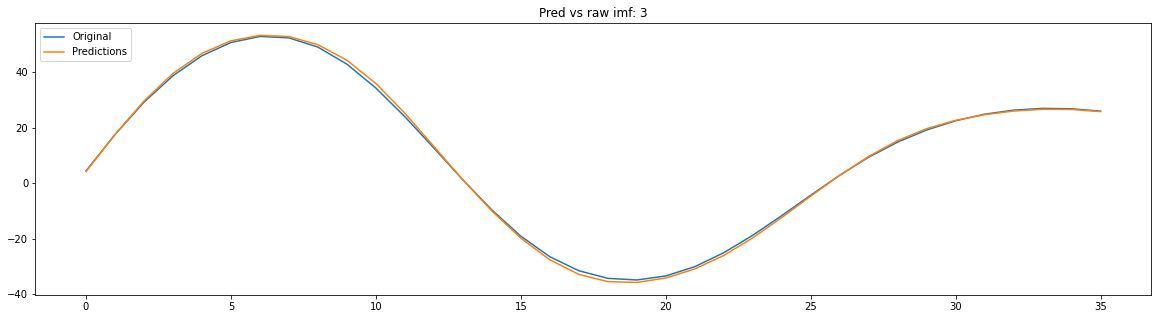

Epoch 1/100
26/26 - 2s - loss: 0.2404 - val_loss: 0.1594
Epoch 2/100
26/26 - 0s - loss: 0.1128 - val_loss: 0.0924
Epoch 3/100
26/26 - 0s - loss: 0.0658 - val_loss: 0.0398
Epoch 4/100
26/26 - 0s - loss: 0.0571 - val_loss: 0.0581
Epoch 5/100
26/26 - 0s - loss: 0.0616 - val_loss: 0.1106
Epoch 6/100
26/26 - 0s - loss: 0.0640 - val_loss: 0.0466
Epoch 7/100
26/26 - 0s - loss: 0.0592 - val_loss: 0.0282
Epoch 8/100
26/26 - 0s - loss: 0.0326 - val_loss: 0.0597
Epoch 9/100
26/26 - 0s - loss: 0.0372 - val_loss: 0.0497
Epoch 10/100
26/26 - 0s - loss: 0.0334 - val_loss: 0.0236
Epoch 11/100
26/26 - 0s - loss: 0.0448 - val_loss: 0.0236
Epoch 12/100
26/26 - 0s - loss: 0.0412 - val_loss: 0.0292
Epoch 13/100
26/26 - 0s - loss: 0.0320 - val_loss: 0.0255
Epoch 14/100
26/26 - 0s - loss: 0.0356 - val_loss: 0.0437
Epoch 15/100
26/26 - 0s - loss: 0.0255 - val_loss: 0.0188
Epoch 16/100
26/26 - 0s - loss: 0.0210 - val_loss: 0.0405
Epoch 17/100
26/26 - 0s - loss: 0.0352 - val_loss: 0.0592
Epoch 18/100
26/26 - 0s

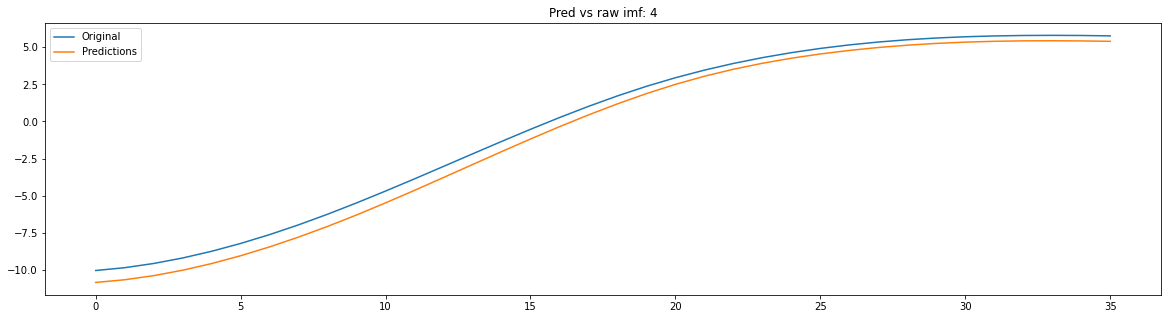

Epoch 1/100
26/26 - 2s - loss: 0.2388 - val_loss: 0.0631
Epoch 2/100
26/26 - 0s - loss: 0.2409 - val_loss: 0.0341
Epoch 3/100
26/26 - 0s - loss: 0.1221 - val_loss: 0.0562
Epoch 4/100
26/26 - 0s - loss: 0.0941 - val_loss: 0.0234
Epoch 5/100
26/26 - 0s - loss: 0.1263 - val_loss: 0.0683
Epoch 6/100
26/26 - 0s - loss: 0.0787 - val_loss: 0.0725
Epoch 7/100
26/26 - 0s - loss: 0.0881 - val_loss: 0.0252
Epoch 8/100
26/26 - 0s - loss: 0.0496 - val_loss: 0.0509
Epoch 9/100
26/26 - 0s - loss: 0.0749 - val_loss: 0.0336
Epoch 10/100
26/26 - 0s - loss: 0.0910 - val_loss: 0.0321
Epoch 11/100
26/26 - 0s - loss: 0.0716 - val_loss: 0.0145
Epoch 12/100
26/26 - 0s - loss: 0.0872 - val_loss: 0.0169
Epoch 13/100
26/26 - 0s - loss: 0.0712 - val_loss: 0.0293
Epoch 14/100
26/26 - 0s - loss: 0.0426 - val_loss: 0.0511
Epoch 15/100
26/26 - 0s - loss: 0.0687 - val_loss: 0.0287
Epoch 16/100
26/26 - 0s - loss: 0.0507 - val_loss: 0.0703
Epoch 17/100
26/26 - 0s - loss: 0.0602 - val_loss: 0.0324
Epoch 18/100
26/26 - 0s

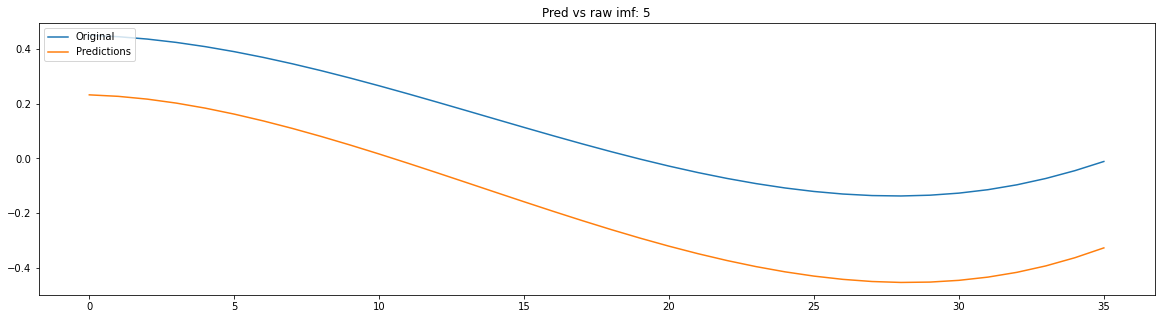

Epoch 1/100
26/26 - 2s - loss: 0.2180 - val_loss: 0.2818
Epoch 2/100
26/26 - 0s - loss: 0.1778 - val_loss: 0.3554
Epoch 3/100
26/26 - 0s - loss: 0.1809 - val_loss: 0.1262
Epoch 4/100
26/26 - 0s - loss: 0.0629 - val_loss: 0.3392
Epoch 5/100
26/26 - 0s - loss: 0.1184 - val_loss: 0.1098
Epoch 6/100
26/26 - 0s - loss: 0.1688 - val_loss: 0.1823
Epoch 7/100
26/26 - 0s - loss: 0.0870 - val_loss: 0.3174
Epoch 8/100
26/26 - 0s - loss: 0.0957 - val_loss: 0.0455
Epoch 9/100
26/26 - 0s - loss: 0.1436 - val_loss: 0.0165
Epoch 10/100
26/26 - 0s - loss: 0.0698 - val_loss: 0.2814
Epoch 11/100
26/26 - 0s - loss: 0.0743 - val_loss: 0.0638
Epoch 12/100
26/26 - 0s - loss: 0.0903 - val_loss: 0.0663
Epoch 13/100
26/26 - 0s - loss: 0.0449 - val_loss: 0.1946
Epoch 14/100
26/26 - 0s - loss: 0.0803 - val_loss: 0.0463
Epoch 15/100
26/26 - 0s - loss: 0.0928 - val_loss: 0.0626
Epoch 16/100
26/26 - 0s - loss: 0.0691 - val_loss: 0.3288
Epoch 17/100
26/26 - 0s - loss: 0.1120 - val_loss: 0.0847
Epoch 18/100
26/26 - 0s

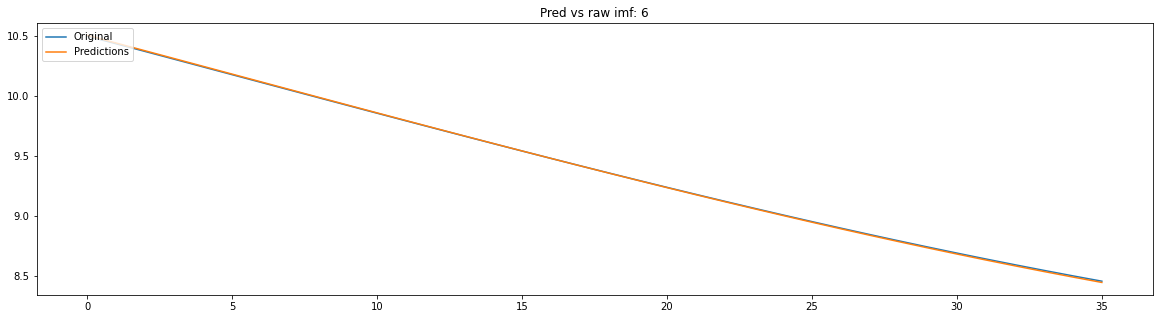

Epoch 1/100
26/26 - 2s - loss: 0.2252 - val_loss: 0.3136
Epoch 2/100
26/26 - 0s - loss: 0.2055 - val_loss: 0.2003
Epoch 3/100
26/26 - 0s - loss: 0.2224 - val_loss: 0.1250
Epoch 4/100
26/26 - 0s - loss: 0.0870 - val_loss: 0.0618
Epoch 5/100
26/26 - 0s - loss: 0.0747 - val_loss: 0.0085
Epoch 6/100
26/26 - 0s - loss: 0.0783 - val_loss: 0.0890
Epoch 7/100
26/26 - 0s - loss: 0.0663 - val_loss: 0.0451
Epoch 8/100
26/26 - 0s - loss: 0.0912 - val_loss: 0.0503
Epoch 9/100
26/26 - 0s - loss: 0.0824 - val_loss: 0.0534
Epoch 10/100
26/26 - 0s - loss: 0.0483 - val_loss: 0.0765
Epoch 11/100
26/26 - 0s - loss: 0.0618 - val_loss: 0.2094
Epoch 12/100
26/26 - 0s - loss: 0.0869 - val_loss: 0.1014
Epoch 13/100
26/26 - 0s - loss: 0.0195 - val_loss: 0.0303
Epoch 14/100
26/26 - 0s - loss: 0.0338 - val_loss: 0.0047
Epoch 15/100
26/26 - 0s - loss: 0.0443 - val_loss: 0.0696
Epoch 16/100
26/26 - 0s - loss: 0.0123 - val_loss: 0.0043
Epoch 17/100
26/26 - 0s - loss: 0.0430 - val_loss: 0.0763
Epoch 18/100
26/26 - 0s

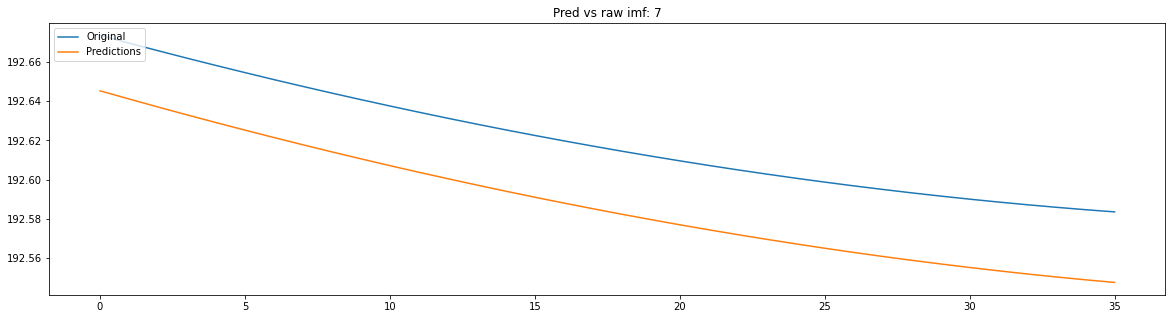

In [9]:
yhats = np.empty((36,len(IMF)),dtype=object)

for j in range(len(IMF)):  
    raw_values = IMF[j].astype('float32')
    
    raw_values= raw_values.reshape(-1,1)
    
    supervised = series_to_supervised(raw_values, 12)
    supervised_values = supervised.values
 
    train, test = supervised_values[0:-36], supervised_values[-36:]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    train_scaled = train_scaled[12:]
    
    X_train, y_train = train_scaled[:,0:-1], train_scaled[:,-1]
    X_train = X_train.reshape(X_train.shape[0], 12, 1)
    
    X_train, y_train, X_valid, y_valid = X_train[:-84], y_train[:-84], X_train[-84:], y_train[-84:]
    
    model = lstm_model()
    model.fit(X_train, y_train, epochs=100, batch_size=12, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)
    
    X_test, y_test = test_scaled[:,0:-1], test_scaled[:,-1]
    X_test = X_test.reshape(X_test.shape[0], 12, 1)

    yhat = model.predict(X_test)

    X_test = X_test.reshape(X_test.shape[0], 12)
    yhat = concatenate((X_test, yhat), axis=1)
    yhat = scaler.inverse_transform(yhat)
    predicted = yhat[:,-1]
    
    # calculate RMSE, MAE, R2
    rmse = sqrt(mean_squared_error(raw_values[-36:], predicted))
    mae = mean_absolute_error(raw_values[-36:], predicted)
    #r2 = r2_score(raw_values[-36:], predicted)
    r2 = r2_det(raw_values[-36:], predicted) 
    print('RMSE: %.3f' % rmse)
    print('MAE: %.3f' % mae)
    print('R2: %.3f' % r2)
    
    plt.figure(figsize=(20,5))
    plt.title('Pred vs raw imf: %i' %j)
    plt.plot(raw_values[-36:], label="Original")
    plt.plot( predicted, label="Predictions")
    plt.legend(loc="upper left")
    plt.show()
          
    yhats[:,j] = predicted;

https://www.researchgate.net/post/Can_we_have_a_negative_R_squared_in_fitting_a_simple_linear_regression_for_exemple_and_how_we_can_explain_this_negative_value




 Test signal RMSE: 73.613
 Test signal MAE : 60.703
 Test signal R2  : 0.636




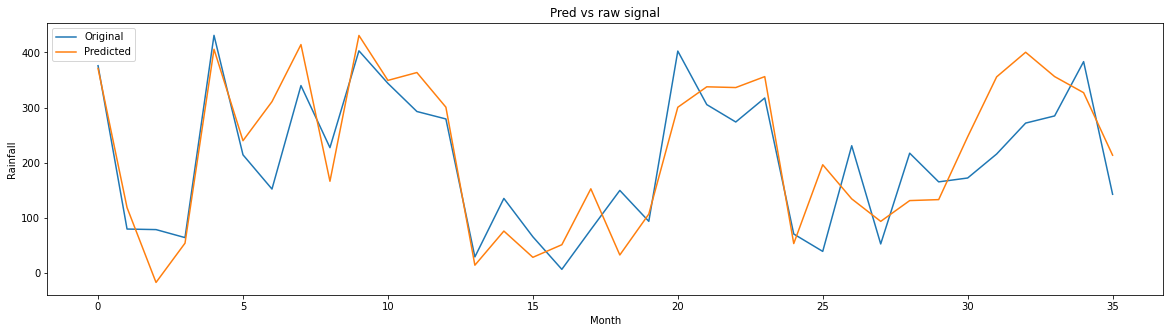

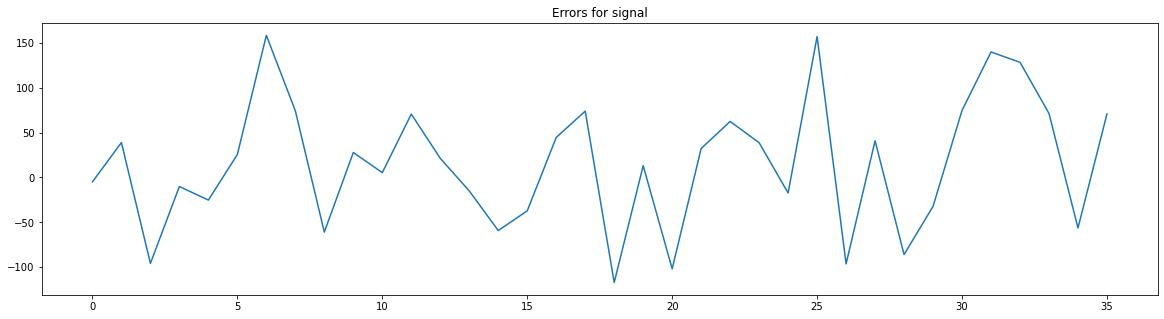

In [10]:
# sum across ensemble members
summed_predictions = np.sum(yhats, axis=1)

summed_rmse = sqrt(mean_squared_error(x[-36:], summed_predictions))
summed_mae = mean_absolute_error(x[-36:], summed_predictions)
summed_r2 = r2_score(x[-36:], summed_predictions)
print('\n\n\n Test signal RMSE: %.3f' %summed_rmse )
print(' Test signal MAE : %.3f' %summed_mae)
print(' Test signal R2  : %.3f' %summed_r2)
print('\n')
        
plt.figure(figsize=(20,5))
plt.title('Pred vs raw signal')
plt.plot(x[-36:], label='Original')
plt.plot(summed_predictions, label='Predicted')
plt.xlabel("Month") 
plt.ylabel("Rainfall")
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(20,5))
plt.title('Errors for signal')
plt.plot(summed_predictions-x[-36:])
plt.show()